In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from global_macro_data import gmd
from datetime import datetime, timedelta

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

plt.style.use('ggplot')

In [2]:
import statsmodels as sm

## Import Data

In [3]:
columns_needed = ["countryname","year","infl","CPI"]

In [4]:
df = gmd(version="2025_01",country="DEU",variables=columns_needed)

Downloading: https://www.globalmacrodata.com/GMD_2025_01.csv
Filtered data for countries: DEU
Selected 5 variables
Final dataset: 705 observations of 5 variables


## Data Cleaning

In [5]:
df[df["infl"].isnull()]

,ISO3,countryname,year,infl,CPI
11528,DEU,Germany,1326,NaN,NaN
11529,DEU,Germany,1327,NaN,NaN
11530,DEU,Germany,1328,NaN,NaN
11531,DEU,Germany,1329,NaN,NaN
11532,DEU,Germany,1330,NaN,NaN
...,...,...,...,...,...
12019,DEU,Germany,1817,NaN,NaN
12020,DEU,Germany,1818,NaN,NaN
12021,DEU,Germany,1819,NaN,NaN
12022,DEU,Germany,1820,NaN,5.067771e-12


In [6]:
nona = pd.notnull(df["infl"])

In [7]:
df_nona = df[nona]

In [8]:
df_nona

,ISO3,countryname,year,infl,CPI
12023,DEU,Germany,1821,-13.636364,4.376712e-12
12024,DEU,Germany,1822,0.000000,4.376712e-12
12025,DEU,Germany,1823,5.263158,4.607065e-12
12026,DEU,Germany,1824,-25.000000,3.455298e-12
12027,DEU,Germany,1825,-3.333333,3.340122e-12
...,...,...,...,...,...
12227,DEU,Germany,2025,2.028653,1.418975e+02
12228,DEU,Germany,2026,1.952566,1.446681e+02
12229,DEU,Germany,2027,1.952475,1.474927e+02
12230,DEU,Germany,2028,1.951673,1.503713e+02


In [9]:
df_nona["Date"] = pd.to_datetime(df_nona['year'],format='%Y')
df_year = df_nona.drop(columns = 'year')
df_year = df_year.set_index("Date")

C:\Users\mic\AppData\Local\Temp\ipykernel_30060\3767496882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nona["Date"] = pd.to_datetime(df_nona['year'],format='%Y')


In [10]:
df_year

,ISO3,countryname,infl,CPI
Date,,,,
1821-01-01,DEU,Germany,-13.636364,4.376712e-12
1822-01-01,DEU,Germany,0.000000,4.376712e-12
1823-01-01,DEU,Germany,5.263158,4.607065e-12
1824-01-01,DEU,Germany,-25.000000,3.455298e-12
1825-01-01,DEU,Germany,-3.333333,3.340122e-12
...,...,...,...,...
2025-01-01,DEU,Germany,2.028653,1.418975e+02
2026-01-01,DEU,Germany,1.952566,1.446681e+02
2027-01-01,DEU,Germany,1.952475,1.474927e+02


<Axes: xlabel='Date'>

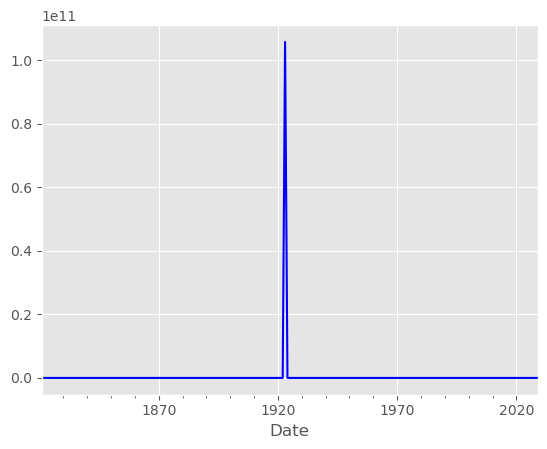

In [11]:
df_year["infl"].plot(color="blue")

In [12]:
max_year = df_year["infl"].max()
max_index = df_year.loc[df_year["infl"] == max_year].index.item()
max_index

Timestamp('1923-01-01 00:00:00')

In [13]:
df_year[str(max_index.year+1):].head()

,ISO3,countryname,infl,CPI
Date,,,,
1924-01-01,DEU,Germany,729.176640,13.719455
1925-01-01,DEU,Germany,8.609272,14.900600
1926-01-01,DEU,Germany,0.609756,14.991457
1927-01-01,DEU,Germany,3.636364,15.536602
1928-01-01,DEU,Germany,2.923977,15.990888


In [14]:
df_1925 = df_year[str(max_index.year+2):]

In [15]:
df_1925

,ISO3,countryname,infl,CPI
Date,,,,
1925-01-01,DEU,Germany,8.609272,14.900600
1926-01-01,DEU,Germany,0.609756,14.991457
1927-01-01,DEU,Germany,3.636364,15.536602
1928-01-01,DEU,Germany,2.923977,15.990888
1929-01-01,DEU,Germany,1.136364,16.172602
...,...,...,...,...
2025-01-01,DEU,Germany,2.028653,141.897460
2026-01-01,DEU,Germany,1.952566,144.668110
2027-01-01,DEU,Germany,1.952475,147.492710


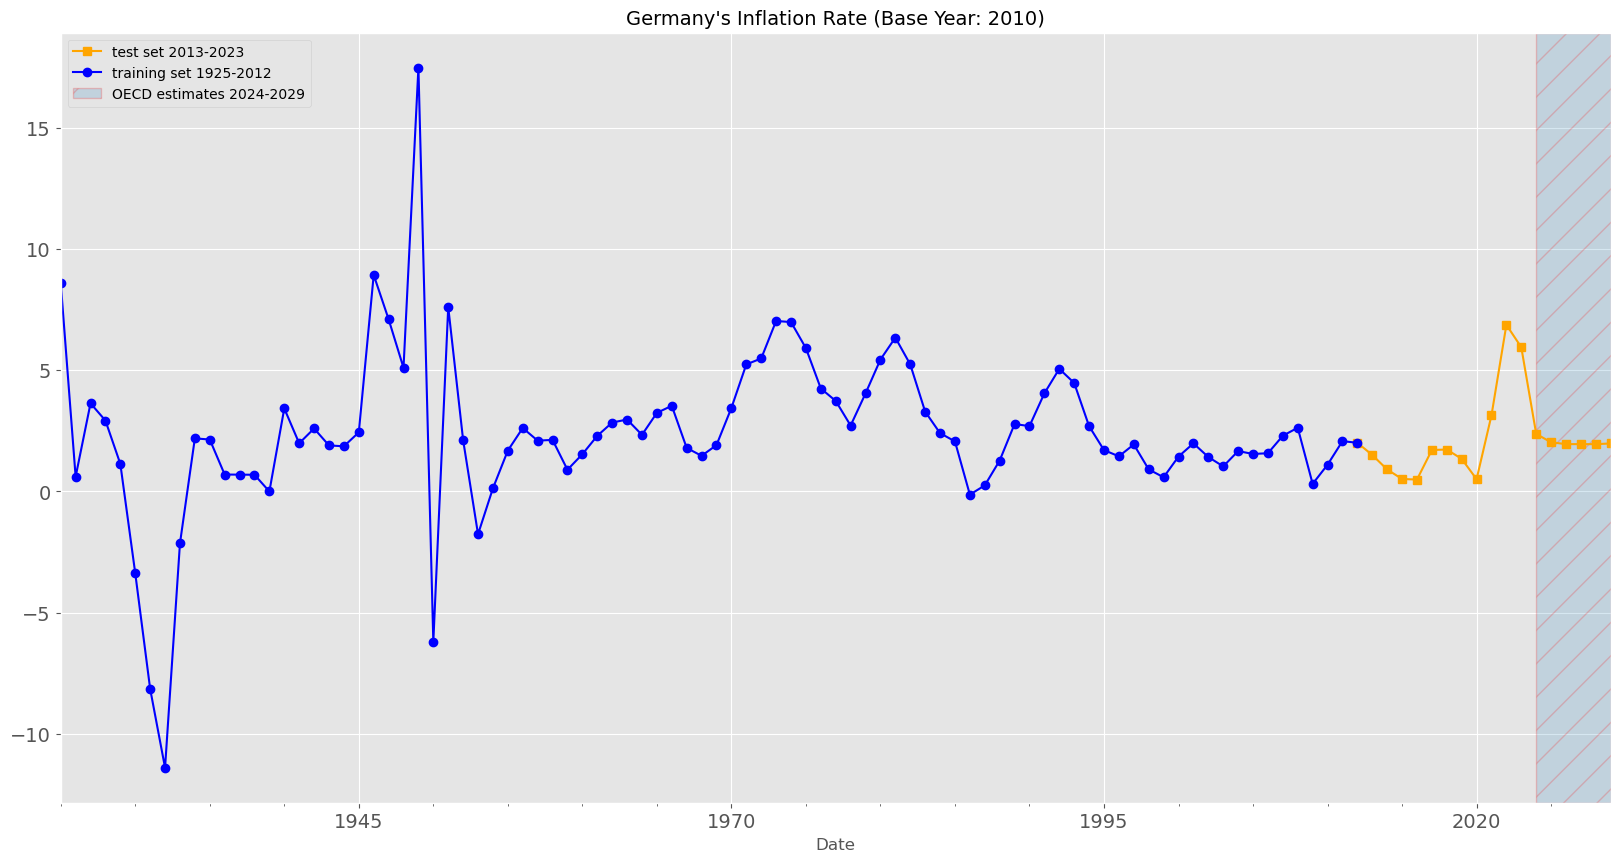

In [16]:
plt.figure(figsize=(20,10))
plt.title("Germany's Inflation Rate (Base Year: 2010)",fontsize=14)
df_1925["2012":]["infl"].plot(label="test set 2013-2023",fontsize=14,color="orange",marker="s")
df_1925[:"2012"]["infl"].plot(label="training set 1925-2012",fontsize=14,color="blue",marker="o")

plt.axvspan(datetime(2024, 1, 1), datetime(2029, 1, 1), alpha=0.2, hatch='/', edgecolor='red', linewidth=1,label="OECD estimates 2024-2029")

plt.legend()
plt.show()

In [17]:
# df_1925.index.to_period("Y")
# df_1925

In [18]:
df_oecd = df_1925["2024":]
df_test = df_1925["2013":"2023"]
df_train = df_1925[:"2012"]

print(df_train.shape,df_test.shape)

(88, 4) (11, 4)


In [19]:
def adf_test(series, **kw):
    statistic, p_value, n_lags, n_obs, critical_values, icbest = adfuller(series, **kw)
    # Format Output
    print(f"ADF Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print(f"num observations: {n_obs}")
    print("Critial Values:")
    for key, value in critical_values.items():
        print(f"   {key} : {value}")
    if p_value < 0.05:
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [20]:
adf_test(df_train["infl"])

ADF Statistic: -3.612055014950639
p-value: 0.005534700157946174
num lags: 4
num observations: 83
Critial Values:
   1% : -3.5117123057187376
   5% : -2.8970475206326833
   10% : -2.5857126912469153
Stationary


The p-value is less than the significance level, the decision is to reject the null hypothesis. Because the data provide evidence that there is no unit root, the recommendation of the analysis is to proceed without differencing.

In [21]:
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print("Critial Values:")
    for key, value in critical_values.items():
        print(f"   {key} : {value}")    
    if p_value < 0.05:
        print("\x1b[31mNon-stationary\x1b[0m")
    else:
        print("\u001b[32mStationary\u001b[0m")

In [22]:
kpss_test(df_train["infl"])

KPSS Statistic: 0.16582435412753024
p-value: 0.1
num lags: 4
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Stationary


C:\Users\mic\AppData\Local\Temp\ipykernel_30060\2968556273.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


The null and alternate hypothesis for the KPSS test are opposite that of the ADF test. The p-value is higher than the significance level, the decision is to not reject the null hypothesis. Because the data provide evidence that the time series is trend-stationary, the recommendation of the analysis is to proceed without differencing.

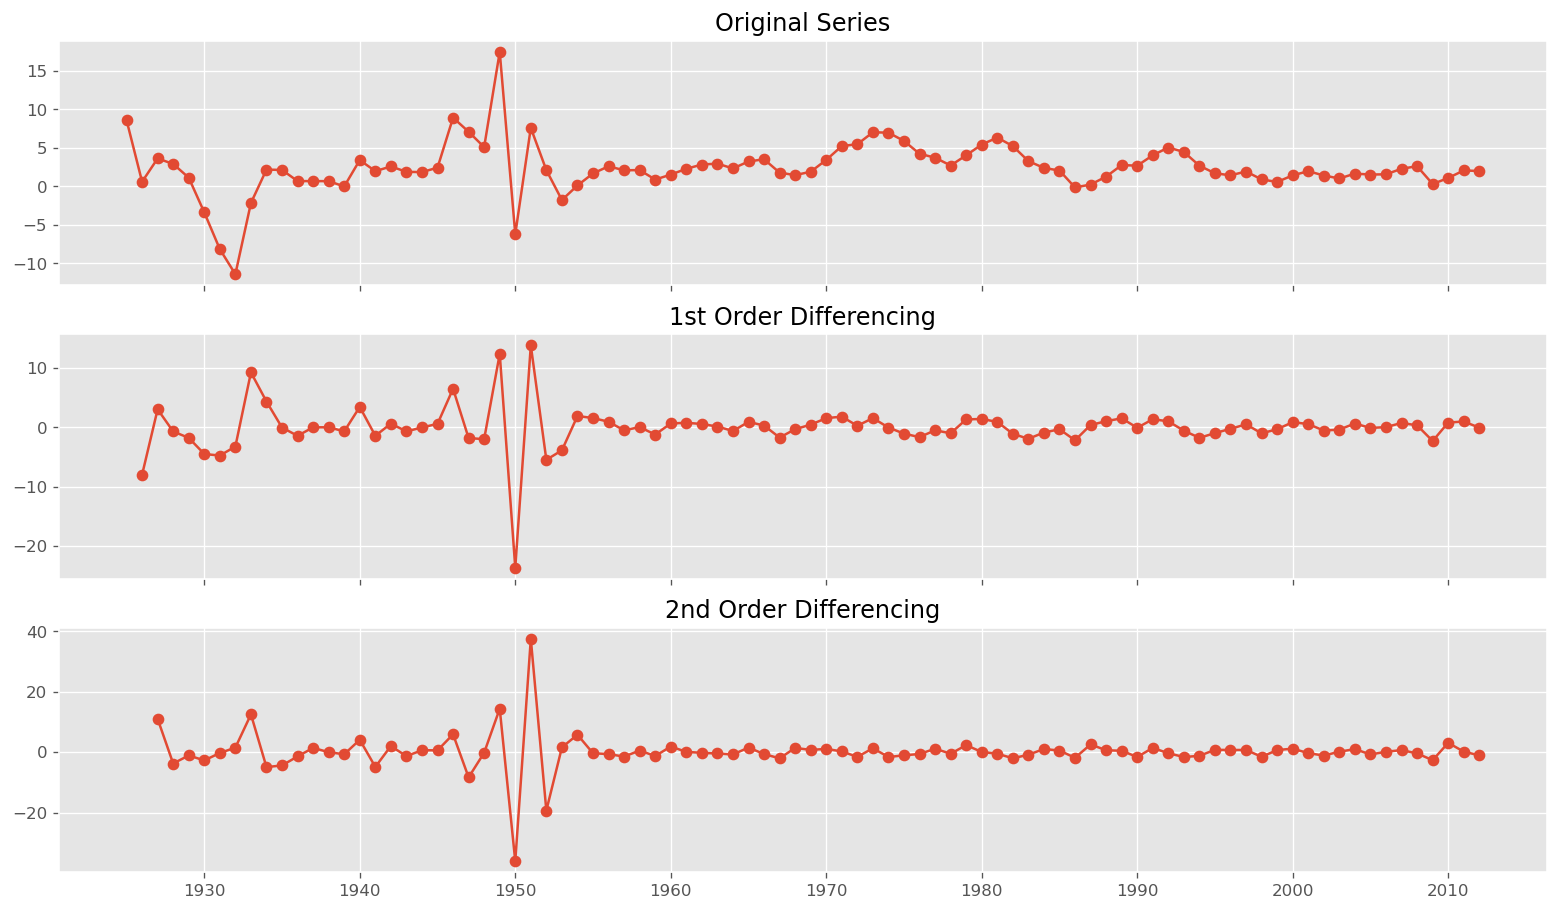

In [23]:
plt.rcParams.update({'figure.figsize':(16,9), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(df_train.infl,marker="o"); axes[0].set_title('Original Series')

# 1st Differencing
axes[1].plot(df_train.infl.diff(),marker="o"); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
axes[2].plot(df_train.infl.diff().diff(),marker="o"); axes[2].set_title('2nd Order Differencing')

plt.show()

Since there is no trend is gone, I will plot the autocorrelation function to review the correlational structure of the time series. This time we use the plot_acf() function.

| | AR($p$) | MA($q$) | ARMA($p$, $q$) |
| :- | :- | :- | :- |
| ACF | Tails off (Geometric decay) | Cuts off after lag $q$ | Tails off after lag $max(0, q - p)$ |
| PACF | Cuts off after lag $p$ | Tails off (Geometric decay) | Tails off after lag $max(0, p - q)$ |

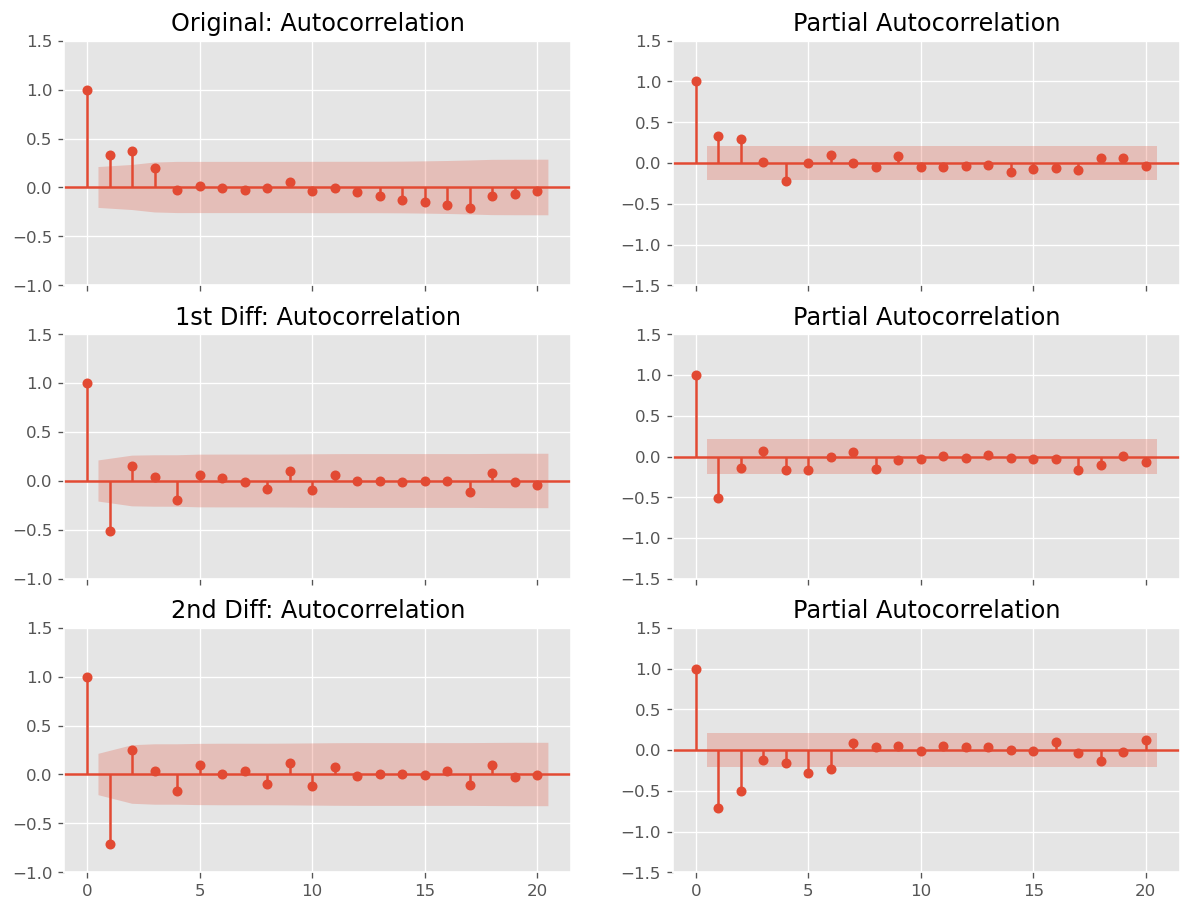

In [24]:
plt.rcParams.update({'figure.figsize':(12,9), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
plot_acf(df_train.infl, ax=axes[0, 0]); axes[0, 0].set_title('Original: Autocorrelation')
plot_pacf(df_train.infl, ax=axes[0, 1])
axes[0,0].set(ylim=(-1,1.5))
axes[0,1].set(ylim=(-1.5,1.5))

# 1st Differencing
plot_acf(df_train.infl.diff().dropna(), ax=axes[1, 0]); axes[1, 0].set_title('1st Diff: Autocorrelation')
plot_pacf(df_train.infl.diff().dropna(), ax=axes[1, 1])
axes[1,0].set(ylim=(-1,1.5))
axes[1,1].set(ylim=(-1.5,1.5))

# 2nd Differencing
plot_acf(df_train.infl.diff().diff().dropna(), ax=axes[2, 0]); axes[2, 0].set_title('2nd Diff: Autocorrelation')
plot_pacf(df_train.infl.diff().diff().dropna(), ax=axes[2, 1])
axes[2,0].set(ylim=(-1,1.5))
axes[2,1].set(ylim=(-1.5,1.5))

plt.show()

It seems that the ACF behaves like a damped sine wave and that the PACF cuts off after lag $p = 2$ in ACF. This is suggesting an ARIMA(2, 0, 0) process.

In [25]:
df_train.index = pd.DatetimeIndex(df_train.index).to_period('Y')

In [26]:
model_arima_1 = ARIMA(df_train.infl, order=(1, 0, 0))
model_arima_1_fit = model_arima_1.fit()
print(model_arima_1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   infl   No. Observations:                   88
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -227.012
Date:                Wed, 21 May 2025   AIC                            460.024
Time:                        16:09:51   BIC                            467.456
Sample:                    12-31-1925   HQIC                           463.019
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4291      0.515      4.721      0.000       1.421       3.438
ar.L1          0.3377      0.042      8.010      0.000       0.255       0.420
sigma2        10.1769      0.707     14.393      0.0

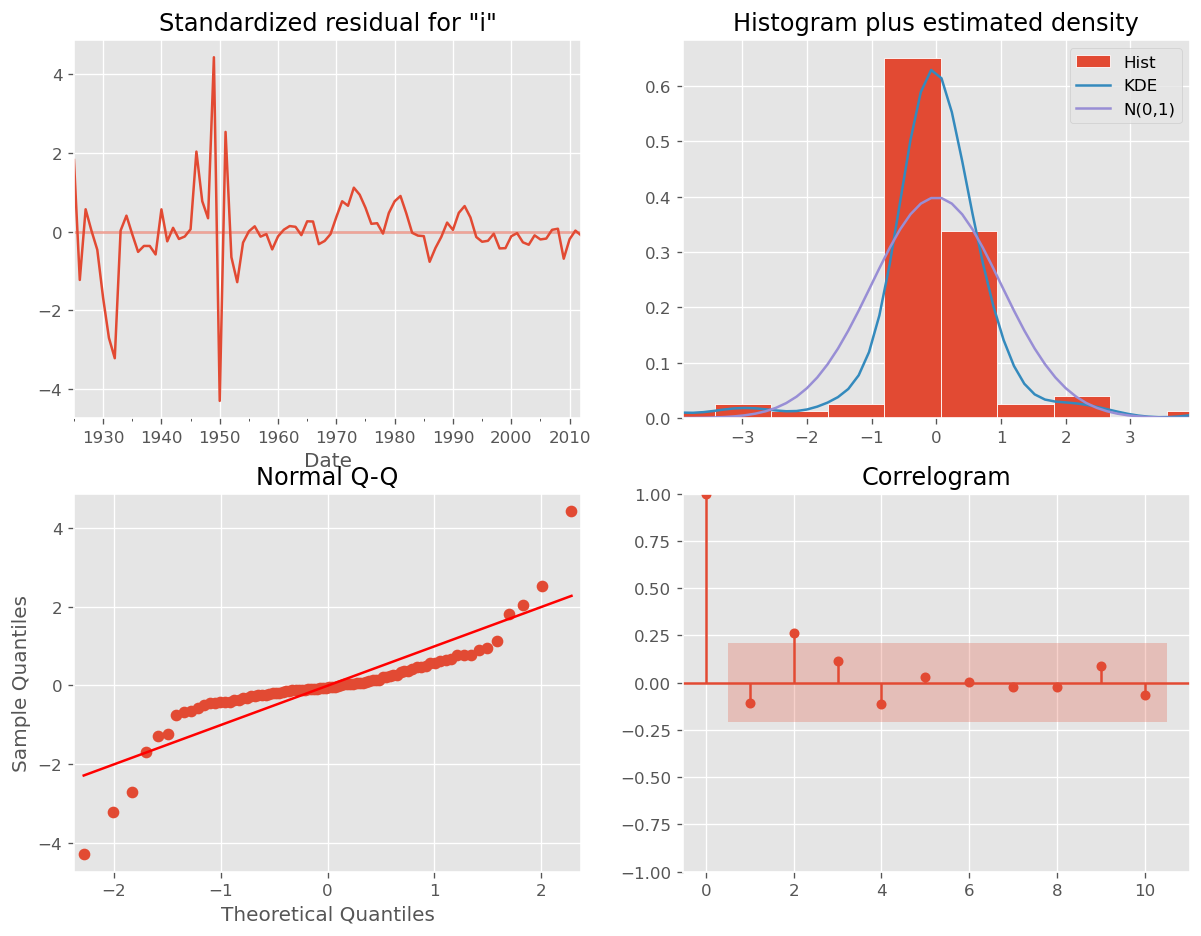

In [27]:
model_arima_1_fit.plot_diagnostics()
plt.show()

In [28]:
model_arima_2 = ARIMA(df_train.infl, order=(2, 0, 1))
model_arima_2_fit = model_arima_2.fit()
print(model_arima_2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   infl   No. Observations:                   88
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -223.083
Date:                Wed, 21 May 2025   AIC                            456.165
Time:                        16:09:53   BIC                            468.552
Sample:                    12-31-1925   HQIC                           461.155
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4530      0.718      3.417      0.001       1.046       3.860
ar.L1          0.2419      0.342      0.708      0.479      -0.428       0.912
ar.L2          0.2937      0.160      1.836      0.0

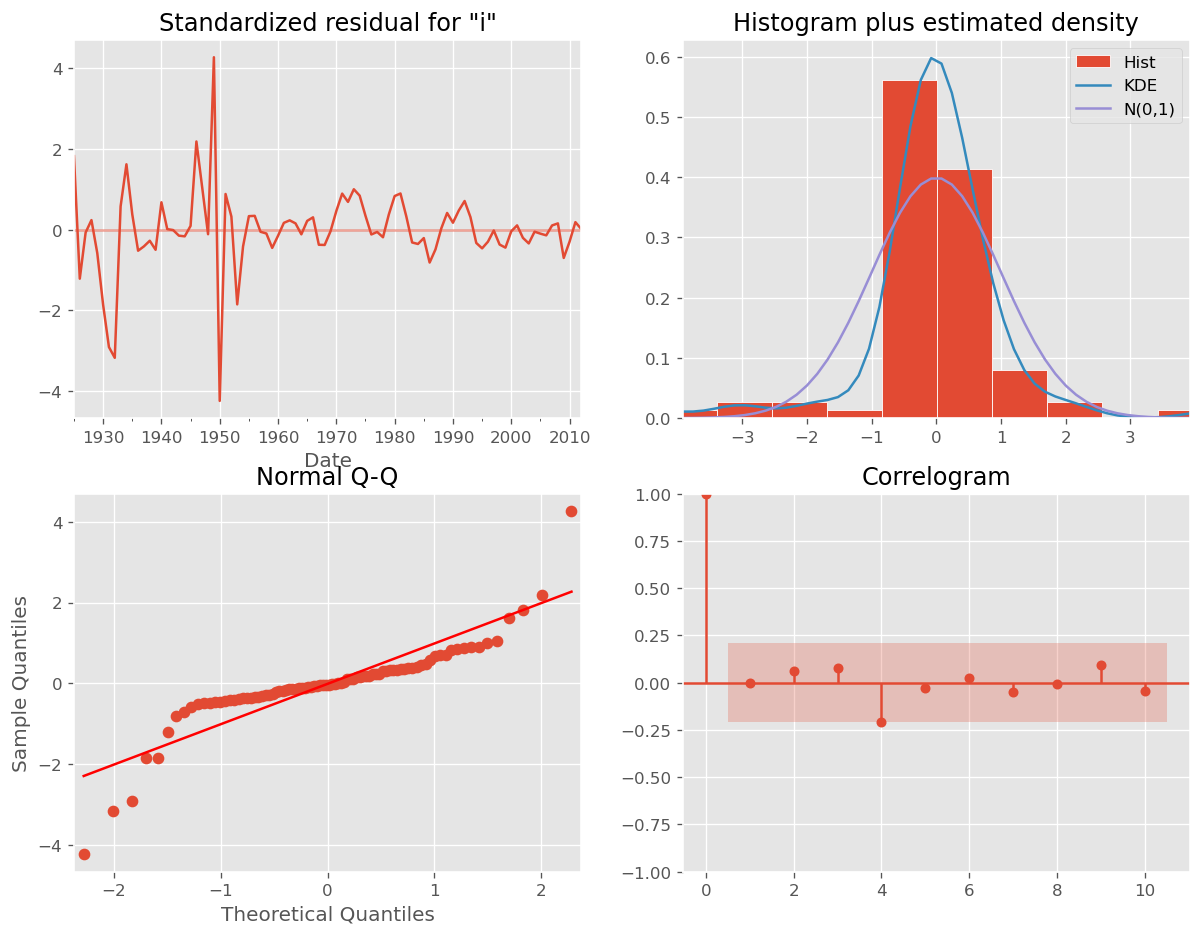

In [29]:
model_arima_2_fit.plot_diagnostics()
plt.show()

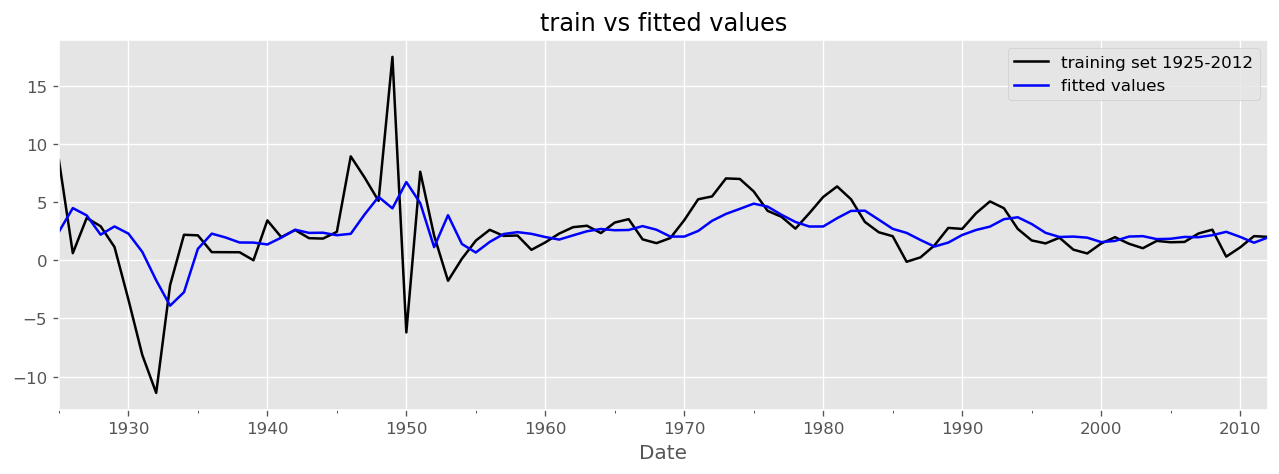

In [30]:
plt.figure(figsize=(13, 4))
plt.title("train vs fitted values")
df_train["infl"].plot(color="black", label="training set 1925-2012")
plt.plot(model_arima_2_fit.fittedvalues, color="blue", label="fitted values")

plt.legend()
plt.show()

In [31]:
forecast_series = model_arima_2_fit.forecast(17)
forecast = model_arima_2_fit.get_forecast(40)
conf_int_95 = forecast.conf_int(alpha=0.05)  # 95% conf
conf_int_80 = forecast.conf_int(alpha=0.2)  # 80% conf

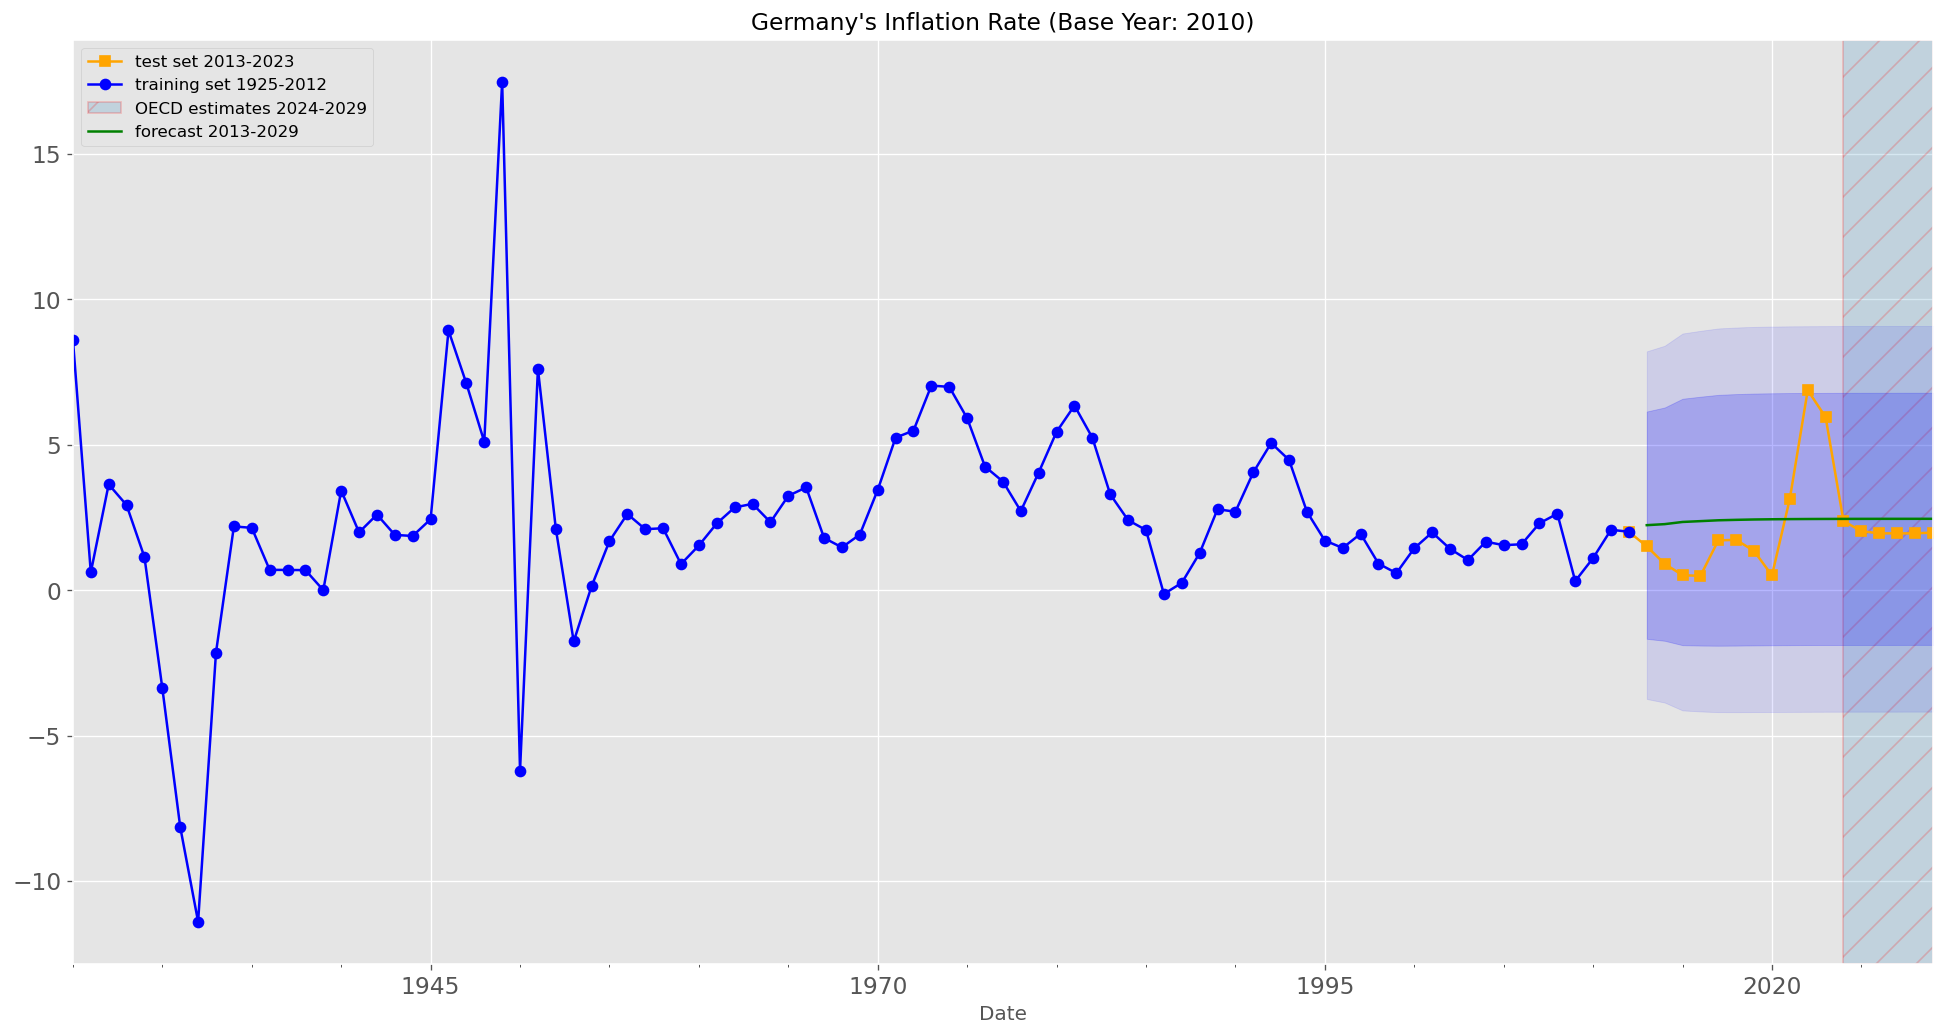

In [32]:
plt.figure(figsize=(20,10))
plt.title("Germany's Inflation Rate (Base Year: 2010)",fontsize=14)
df_1925["2012":]["infl"].plot(label="test set 2013-2023",fontsize=14,color="orange",marker="s")
df_1925[:"2012"]["infl"].plot(label="training set 1925-2012",fontsize=14,color="blue",marker="o")

plt.axvspan(datetime(2024, 1, 1), datetime(2029, 1, 1), alpha=0.2, hatch='/', edgecolor='red', linewidth=1,label="OECD estimates 2024-2029")


plt.plot(forecast_series, label="forecast 2013-2029", color="green")


plt.fill_between(
    conf_int_95.index,
    conf_int_95["lower infl"],
    conf_int_95["upper infl"],
    color="b",
    alpha=0.1,
)

plt.fill_between(
    conf_int_80.index,
    conf_int_80["lower infl"],
    conf_int_80["upper infl"],
    color="b",
    alpha=0.2,
)

plt.legend()
plt.show()